In [4]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import json
import gcsfs
from dask.diagnostics import ProgressBar

# 👇 replace with your key 
with open('/home/jovyan/keys/pangeo-forge-ocean-transport-4967-347e2048c5a1.json') as token_file:
    token = json.load(token_file)
fs = gcsfs.GCSFileSystem(token=token)
subfolder_full = 'ocean-transport-group/scale-aware-air-sea/outputs/temp/'
subfolder_final = 'ocean-transport-group/scale-aware-air-sea/outputs/'

In [32]:
# reload the final store (needs the first cell to be executed, but should otherwise work independently)
path = f'{subfolder_final}CM26_final_output.zarr'# 5 year version
# path = f'{subfolder_final}CM26_final_output_full_time.zarr' # full time (20yrs)
mapper = fs.get_mapper(path)
ds_plot = xr.open_dataset(mapper, engine='zarr', consolidated=True, use_cftime=True, chunks='auto')

ds_plot = ds_plot.sel(yt_ocean=slice(-60,60))

In [33]:
with ProgressBar():
    ds_mean = ds_plot.mean('time').load()

[########################################] | 100% Completed |  1min 37.5s


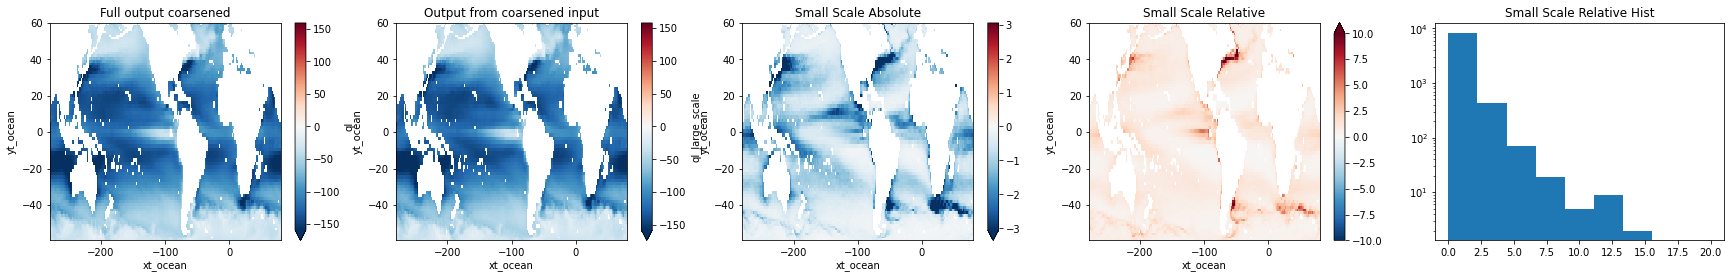

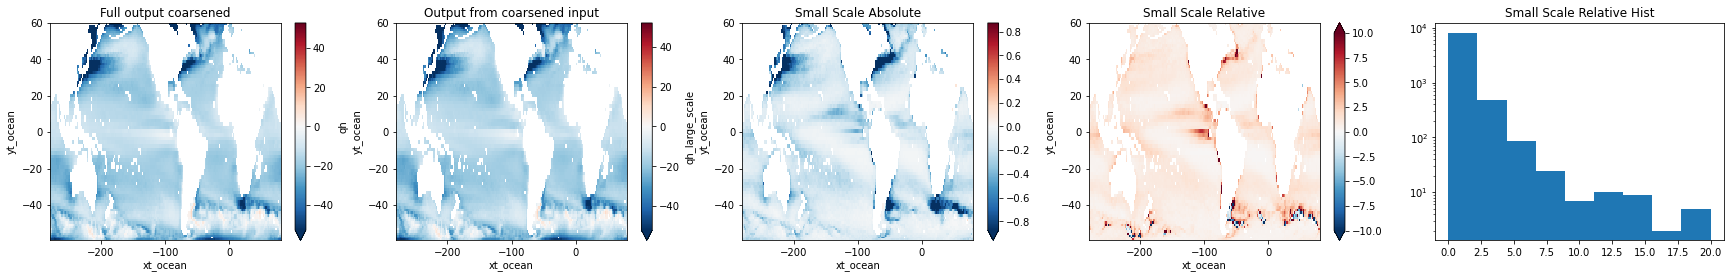

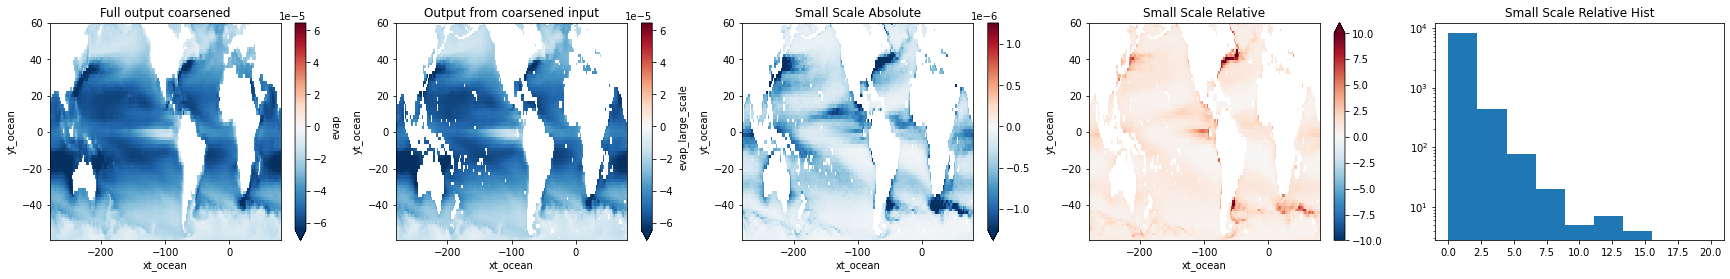

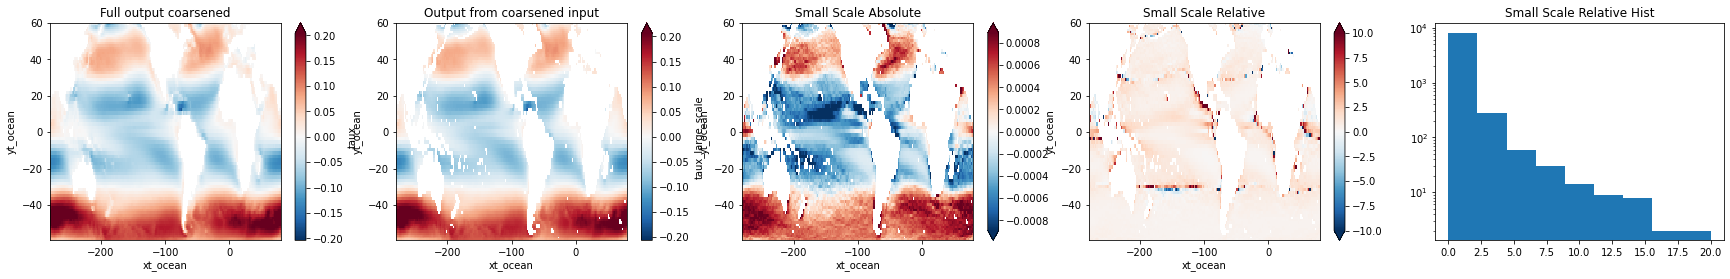

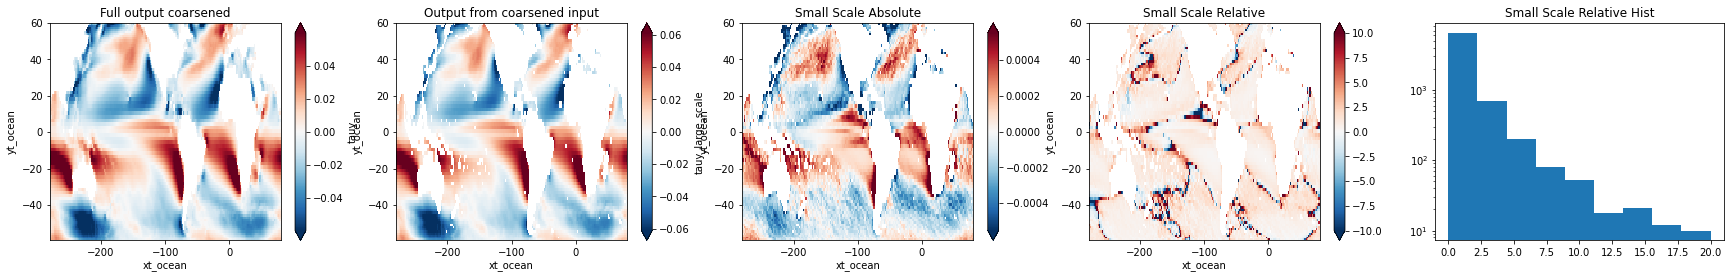

In [34]:
for var in ['ql', 'qh', 'evap', 'taux', 'tauy']:
    with ProgressBar():
        full = ds_mean[var]
        large_scale = ds_mean[var+'_large_scale']
        small_scale = full-large_scale

        # not quite sure if we should look at the mean of the difference or the difference of the mean over time...
        plot_kwargs = {'y':'yt_ocean', 'robust':True, 'center':0}
        plt.figure(figsize=[30,4])
        plt.subplot(1,5,1)
        full.plot(**plot_kwargs)
        plt.title('Full output coarsened')
        plt.subplot(1,5,2)
        large_scale.plot(**plot_kwargs)
        plt.title('Output from coarsened input')
        plt.subplot(1,5,3)
        small_scale.plot(**plot_kwargs)
        plt.title('Small Scale Absolute')
        plt.subplot(1,5,4)
        (small_scale/full*100).plot(vmax=10, **plot_kwargs)
        plt.title('Small Scale Relative')
        
        plt.subplot(1,5,5)
        (small_scale/full*100).plot.hist(bins=np.linspace(0,20,10))
        plt.yscale('log')
        plt.title('Small Scale Relative Hist')
        plt.show()

In [35]:
with ProgressBar():
    ds_seasonal = ds_plot.groupby('time.season').mean('time').load()
ds_seasonal = ds_seasonal.sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'], dims=['season']))

/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/srv/conda/envs/notebook/

[########################################] | 100% Completed |  1min 35.2s


In [36]:
ds_seasonal = ds_seasonal.sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'], dims=['season']))

<Figure size 2160x288 with 0 Axes>

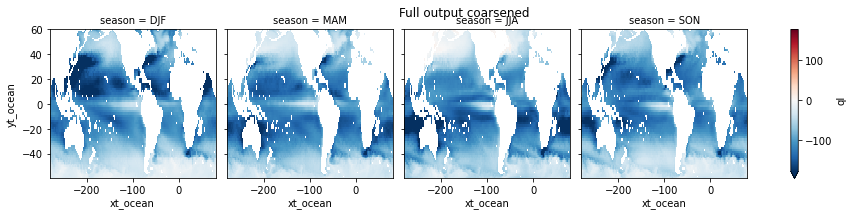

<Figure size 2160x288 with 0 Axes>

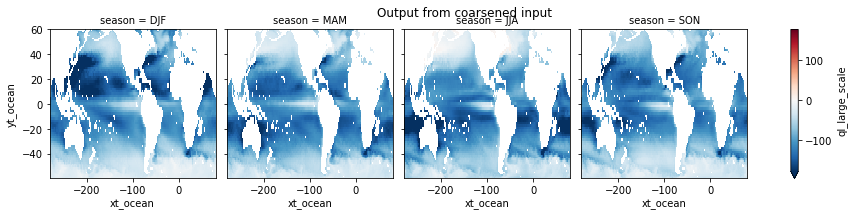

<Figure size 2160x288 with 0 Axes>

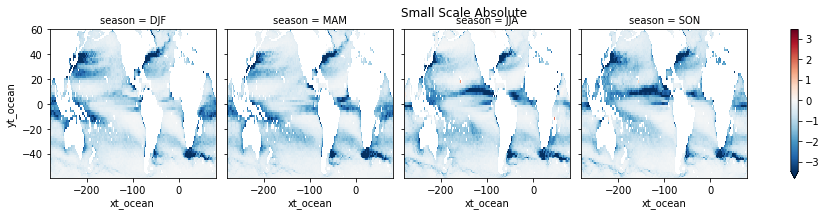

<Figure size 2160x288 with 0 Axes>

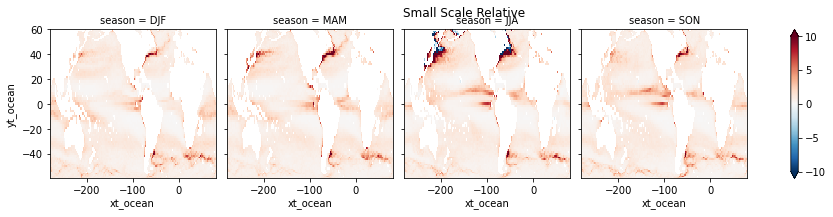

<Figure size 2160x288 with 0 Axes>

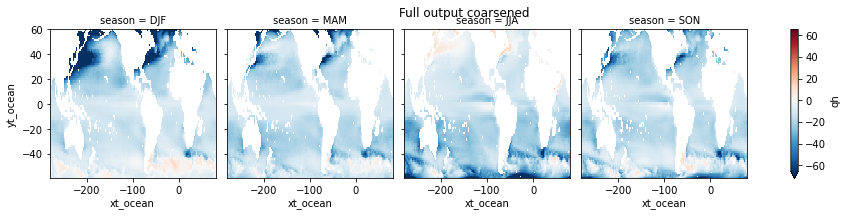

<Figure size 2160x288 with 0 Axes>

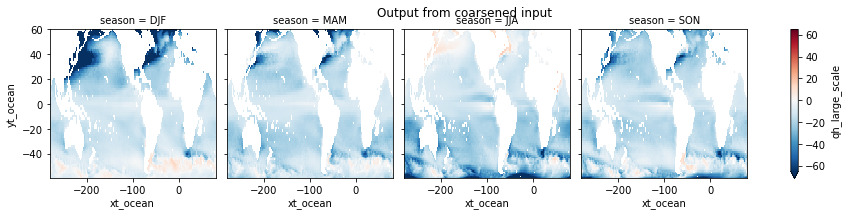

<Figure size 2160x288 with 0 Axes>

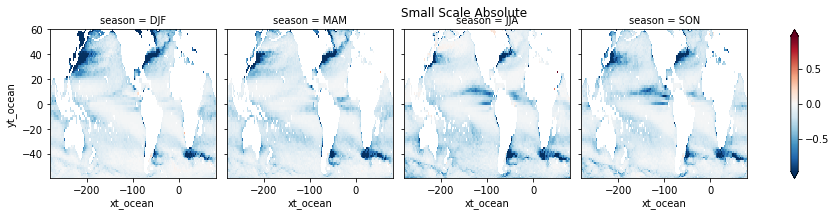

<Figure size 2160x288 with 0 Axes>

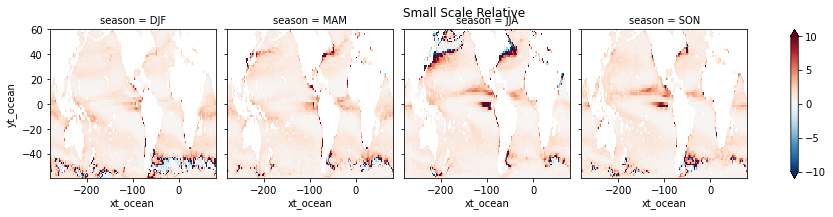

<Figure size 2160x288 with 0 Axes>

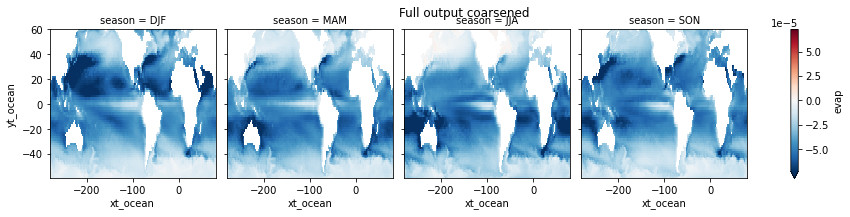

<Figure size 2160x288 with 0 Axes>

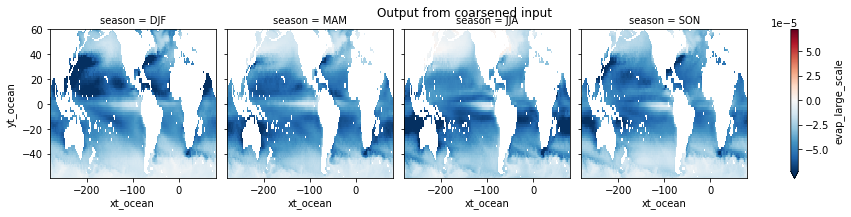

<Figure size 2160x288 with 0 Axes>

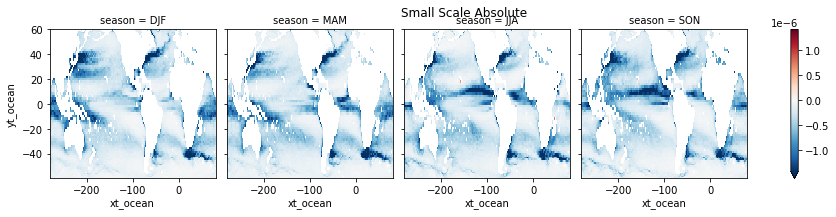

<Figure size 2160x288 with 0 Axes>

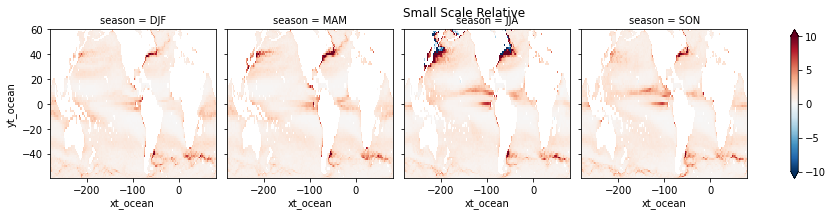

<Figure size 2160x288 with 0 Axes>

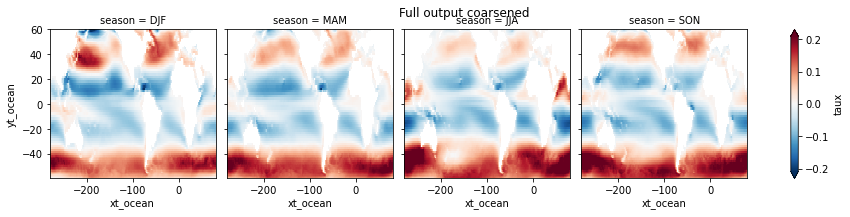

<Figure size 2160x288 with 0 Axes>

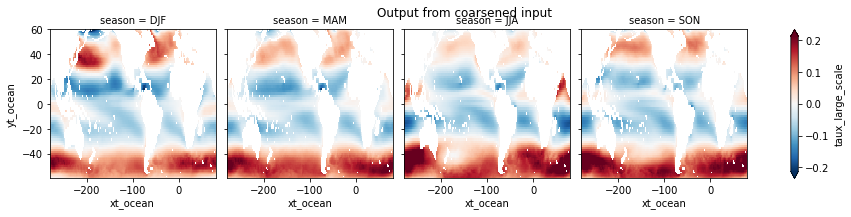

<Figure size 2160x288 with 0 Axes>

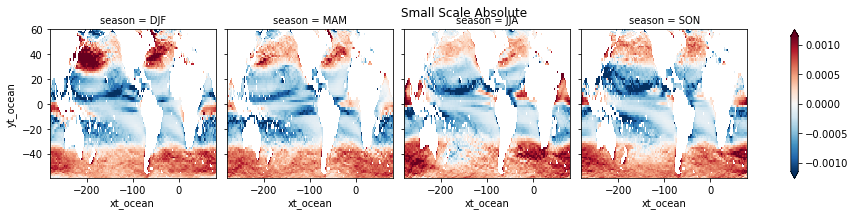

<Figure size 2160x288 with 0 Axes>

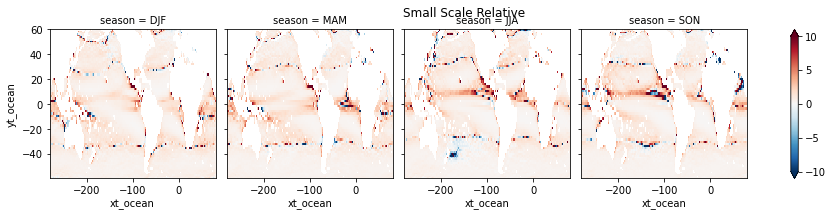

<Figure size 2160x288 with 0 Axes>

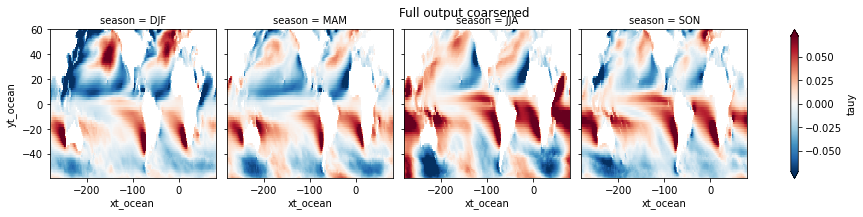

<Figure size 2160x288 with 0 Axes>

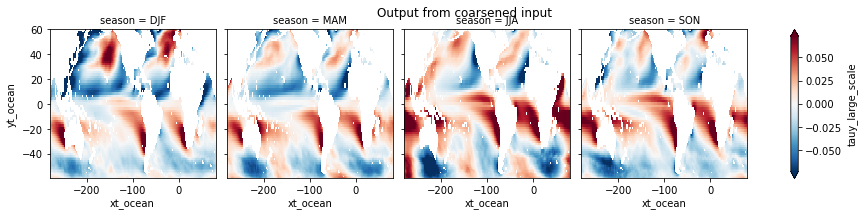

<Figure size 2160x288 with 0 Axes>

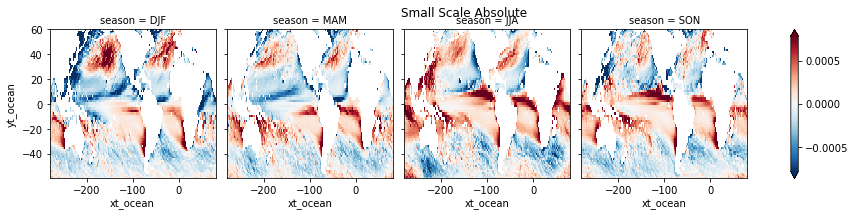

<Figure size 2160x288 with 0 Axes>

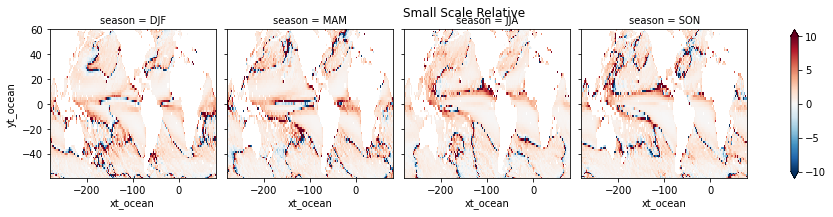

In [37]:
# Check out the seasonal cycle
for var in ['ql', 'qh', 'evap', 'taux', 'tauy']:
    with ProgressBar():
        full = ds_seasonal[var]
        large_scale = ds_seasonal[var+'_large_scale']
        small_scale = full-large_scale

        # not quite sure if we should look at the mean of the difference or the difference of the mean over time...
        plot_kwargs = {'y':'yt_ocean', 'robust':True, 'center':0, 'col':'season'}
        
        plt.figure(figsize=[30,4])
        full.plot(**plot_kwargs)
        plt.suptitle('Full output coarsened', y=0.99)
        
        plt.figure(figsize=[30,4])
        large_scale.plot(**plot_kwargs)
        plt.suptitle('Output from coarsened input', y=0.99)
        
        plt.figure(figsize=[30,4])
        small_scale.plot(**plot_kwargs)
        plt.suptitle('Small Scale Absolute', y=0.99)
        
        plt.figure(figsize=[30,4])
        (small_scale/full*100).plot(vmax=10, **plot_kwargs)
        plt.suptitle('Small Scale Relative', y=0.99)
        plt.show()